# **Introduction to PyTorch**
## Image Processing and Computer Vision - Lab Session No. 4

Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Based on the [UvA Deep Learning Course](https://uvadlc.github.io).

## Import dependencies

In [ ]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T, datasets

## Runtime settings

For this hands-on session and the next one, we are going to train on GPUs. To request a GPU for you virtual machine in Colab, you should change your runtime type:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/uc14.png)

## PyTorch basics

We will start with reviewing the very basic concepts of PyTorch. As a prerequisite, we recommend to be familiar with the `numpy` package as most machine learning frameworks are based on very similar concepts. If you are not familiar with NumPy yet, don't worry: here is a [tutorial](https://numpy.org/devdocs/user/quickstart.html) to go through.

So, let's start with importing PyTorch. The package is called `torch`, based on its original framework [Torch](http://torch.ch/). As a first step, we can check its version:

In [ ]:
import torch
print("Using torch", torch.__version__)

Using torch 2.2.1+cu121


### Reproducibility
When **developing and debugging** neural networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disables the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime.

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

### Tensors

Tensors are the PyTorch equivalent to NumPy arrays, with the addition of also having support for GPU acceleration (more on that later).
The name "tensor" is a generalization of concepts you already know. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

Most common functions you know from NumPy can be used on tensors as well. Actually, since NumPy arrays are so similar to tensors, we can convert most tensors to NumPy arrays (and back), although we don't need it too often.

#### Initialization

Let's first start by looking at different ways of creating a tensor. There are many possible options, the simplest one is to call `torch.Tensor` passing the desired shape as input argument:

In [ ]:
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[1.2218e-26, 2.8422e-14, 9.7891e+18, 4.4160e+21],
         [2.1533e-29, 1.1433e+27, 1.8465e+25, 5.5350e-11],
         [4.5038e+30, 2.8026e-45, 3.7471e-42, 4.2736e+31]],

        [[1.8061e+28, 3.1655e-40, 2.8447e-36, 2.5353e+30],
         [2.6625e-44, 3.0934e+32, 4.5442e+30, 2.5223e-44],
         [7.3344e-42, 1.2348e-39, 7.4572e-31, 2.5353e+30]]])


The function `torch.Tensor` allocates memory for the desired tensor, but reuses any values that have already been stored in the memory by default underlying processes (*uninitialized memory*). To directly assign values to the tensor during initialization, there are many alternatives including:

* `torch.zeros`: creates a tensor filled with zeros
* `torch.ones`: creates a tensor filled with ones
* `torch.rand`: creates a tensor with random values uniformly sampled between 0 and 1
* `torch.randn`: creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
* `torch.arange`: creates a tensor containing the values $N,N+1,N+2,...,M$
* `torch.Tensor` (input list): creates a tensor from the list elements you provide

In [ ]:
# Create a tensor from a (nested) list
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


In [ ]:
# Create a tensor with random values between 0 and 1 with the shape [2, 3, 4]
x = torch.rand(2, 3, 4)
print(x)
print(x.shape)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])
torch.Size([2, 3, 4])


#### Tensor to NumPy, and NumPy to Tensor

PyTorch tensors can be converted to NumPy arrays, and NumPy arrays back to tensors. To transform a NumPy array into a tensor, we can use the function `torch.from_numpy`:

In [ ]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print(f"NumPy array:\n{np_arr}")
print(f"\nPyTorch tensor:\n{tensor}")

NumPy array:
[[1 2]
 [3 4]]

PyTorch tensor:
tensor([[1, 2],
        [3, 4]])


To transform a PyTorch tensor back to a NumPy array, we can use the function `.numpy()` on tensors:

In [ ]:
tensor = torch.arange(4)
np_arr = tensor.numpy()

print(f"PyTorch tensor:\n{tensor}")
print(f"\nNumpy array:\n{np_arr}")

PyTorch tensor:
tensor([0, 1, 2, 3])

Numpy array:
[0 1 2 3]


The conversion of tensors to NumPy requires the tensor to be on the CPU, and not the GPU (more on GPU support in a later section). In case you have a tensor on GPU, you need to call `.cpu()` on the tensor beforehand. Hence, you get a line like `np_arr = tensor.cpu().numpy()`.

#### Basic operations


In [ ]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print(f"X1:\n{x1}")
print(f"X2:\n{x2}")
print(f"Y:\n{y}")

X1:
tensor([[0.1053, 0.2695, 0.3588],
        [0.1994, 0.5472, 0.0062]])
X2:
tensor([[0.9516, 0.0753, 0.8860],
        [0.5832, 0.3376, 0.8090]])
Y:
tensor([[1.0569, 0.3448, 1.2448],
        [0.7826, 0.8848, 0.8151]])


In-place operations are usually marked with a underscore postfix (e.g. `add_` instead of `add`):

In [ ]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
print(f"X1 (before):\n{x1}")
print(f"X2 (before):\n{x2}")

x2.add_(x1)
print(f"X1 (after):\n{x1}")
print(f"X2 (after):\n{x2}")

X1 (before):
tensor([[0.5779, 0.9040, 0.5547],
        [0.3423, 0.6343, 0.3644]])
X2 (before):
tensor([[0.7104, 0.9464, 0.7890],
        [0.2814, 0.7886, 0.5895]])
X1 (after):
tensor([[0.5779, 0.9040, 0.5547],
        [0.3423, 0.6343, 0.3644]])
X2 (after):
tensor([[1.2884, 1.8504, 1.3437],
        [0.6237, 1.4230, 0.9539]])


Another common operation aims at changing the shape of a tensor. A tensor of size (2,3) can be re-organized to any other shape with the same number of elements (e.g. a tensor of size (6) or (3,2)). In PyTorch, this operation is called `view`:

In [ ]:
x = torch.arange(6)
print(f"X:\n{x}")

X:
tensor([0, 1, 2, 3, 4, 5])


In [ ]:
x = x.view(2, 3)
print(f"X:\n{x}")

X:
tensor([[0, 1, 2],
        [3, 4, 5]])


In [ ]:
x = x.permute(1, 0)  # swap dimension 0 and 1
print(f"X:\n{x}")

X:
tensor([[0, 3],
        [1, 4],
        [2, 5]])


### GPU support

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
x = torch.zeros(2, 3)
x = x.to(device)
print(f"X:\n{x}")

X:
tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In case you have a GPU, you should now see the attribute `device='cuda:0'` being printed next to your tensor. The `0` next to `cuda` indicates that this is the `0`-th GPU device on your computer. PyTorch also supports multi-GPU systems, but you will only need this feature once you have very big networks to train (if interested, see the [PyTorch documentation](https://pytorch.org/docs/stable/distributed.html#distributed-basics)). We can also compare the runtime of a large matrix multiplication on the CPU with the same operation on the GPU:

In [ ]:
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # first operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # wait for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # milliseconds to seconds

CPU time: 5.66470s
GPU time: 0.08761s


### Dynamic Computation Graph and Backpropagation

One of the main reasons for using PyTorch in Deep Learning projects is that we can automatically get **gradients/derivatives** of functions that we define. We will mainly use PyTorch for implementing neural networks, and they are just fancy functions. If we use weight matrices in our function that we want to learn, then those are called the **parameters** or simply the **weights**.

If our neural network would output a single scalar value, we would talk about taking the **derivative**, but you will see that quite often we will have **multiple** output variables ("values"); in that case we talk about **gradients**. It's a more general term.

Given an input $\mathbf{x}$, we define our function by **manipulating** that input, usually by matrix-multiplications with weight matrices and additions with so-called bias vectors. As we manipulate our input, we are automatically creating a **computational graph**. This graph shows how to arrive at our output from our input.
PyTorch is a **define-by-run** framework; this means that we can just do our manipulations, and PyTorch will keep track of that graph for us. Thus, we create a dynamic computation graph along the way.

So, to recap: the only thing we have to do is to compute the **output**, and then we can ask PyTorch to automatically get the **gradients**.

> **Note:  Why do we want gradients?** Consider that we have defined a function, a neural net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is; how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want.

The first thing we have to do is to specify which tensors require gradients. By default, when we create a tensor, it does not require gradients.

In [ ]:
x = torch.ones((3,))
print(x.requires_grad)

False


We can change this for an existing tensor using the function `requires_grad_()` (underscore indicating that this is a in-place operation). Alternatively, when creating a tensor, you can pass the argument `requires_grad=True` to most initializers we have seen above.

In [ ]:
x.requires_grad_(True)
print(x.requires_grad)

True


In order to get familiar with the concept of a computation graph, we will create one for the following function:

$$y = \frac{1}{N}\sum_{i=1}^N\left[(x_i + 2)^2 + 3\right]$$

where $N$ denotes the number of elements in $\mathbf{x}$. You could imagine that $\mathbf{x}$ are our parameters, and we want to optimize (either maximize or minimize) the output $y$. For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$. For our example, we'll use $\mathbf{x}=[0,1,2]$ as our input.

In [ ]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)  # only float tensors can have gradients
print(f"X:\n{x}")

X:
tensor([0., 1., 2.], requires_grad=True)


Now let's build the computation graph step by step. You can combine multiple operations in a single line, but we will separate them here to get a better understanding of how each operation is added to the computation graph.

In [ ]:
a = x + 2
print("a:", a)
b = a ** 2
print("b:", b)
c = b + 3
print("c:", c)
y = c.mean()
print("Y:", y)

a: tensor([2., 3., 4.], grad_fn=<AddBackward0>)
b: tensor([ 4.,  9., 16.], grad_fn=<PowBackward0>)
c: tensor([ 7., 12., 19.], grad_fn=<AddBackward0>)
Y: tensor(12.6667, grad_fn=<MeanBackward0>)


Using the statements above, we have created a computation graph that looks similar to the figure below:



We calculate $a$ based on the inputs $\mathbf{x}$ and the constant $2$, $b$ is $a$ squared, and so on. The visualization is an abstraction of the dependencies between inputs and outputs of the operations we have applied.
Each node of the computation graph has automatically defined a function for calculating the gradients with respect to its inputs, `grad_fn`. You can see this when we printed the output tensor $y$ and the intermediate tensors $a,b,c$. This is why the computation graph is usually visualized in the reverse direction (arrows point from the result to the inputs). We can perform backpropagation on the computation graph by calling the function `backward()` on the last output, which effectively calculates the gradients for each tensor that has the property `requires_grad=True`:

In [ ]:
y.backward()

`x.grad` will now contain the gradient $\partial y/ \partial \mathbf{x}$, and this gradient indicates how a change in $\mathbf{x}$ will affect output $y$ given the current input $\mathbf{x}=[0,1,2]$:

In [ ]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


We can also verify these gradients by hand. We will calculate the gradients using the chain rule, in the same way as PyTorch did it:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. Since

$$
a_i=x_i+2, \quad
b_i=a_i^2, \quad
c_i=b_i+3, \quad
y=\frac{1}{N}\sum_{i=1}^N c_i
$$

The partial derivatives are:

$$
\frac{\partial a_i}{\partial x_i} = 1, \hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i, \hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1, \hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}
$$

Hence $\partial y/\partial x_i=\frac{2}{3}(x_i+2)$.

Thus, being the input $\mathbf{x}=[0,1,2]$, our gradients are $\partial y/\partial \mathbf{x}=[4/3,2,8/3]$. The previous code cell should have printed the same result.

## Let's build our first Neural Network!

We are now going to create a simple neural network that classifies images from the [Street View House Numbers (SVHN) dataset](http://ufldl.stanford.edu/housenumbers/):

![](https://miro.medium.com/v2/resize:fit:1200/1*X-VO9sZXIaHxh3aF-CRXZg.png)

SVHN contains 600K 32x32 RGB images of printed digits (from 0 to 9) cropped from pictures of house number plates.

### Prepare the data

Download the dataset:

In [ ]:
tsfms = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.flatten())
])
train_dset = datasets.SVHN(
    root="/data/",
    split="train",
    transform=tsfms,
    download=True
)
test_dset = datasets.SVHN(
    root="/data/",
    split="test",
    transform=tsfms,
    download=True
)
n_classes = 10
input_dim = len(train_dset[0][0])

100%|██████████| 182040794/182040794 [00:05<00:00, 31386580.16it/s]


100%|██████████| 64275384/64275384 [00:01<00:00, 33250233.62it/s]


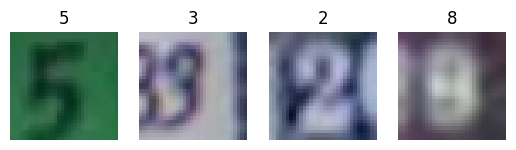

In [ ]:
_, ax = plt.subplots(1, 4)

for i, idx in enumerate([0, 10, 20, 30]):
    img, label = test_dset[idx]
    ax[i].imshow(img.reshape(3, 32, 32).permute(1, 2, 0))
    ax[i].set_title(label)
    ax[i].axis("off")

Create a small validation set from the training set:

In [ ]:
split_dsets = random_split(
    train_dset,
    [len(train_dset) - 5000, 5000]
)
train_subdset = split_dsets[0]
val_subdset = split_dsets[1]

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the `__getitem__` function, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: number of samples to stack per batch.
* `shuffle`: if True, the data is returned in a random order. This is important during training for introducing stochasticity.
* `num_workers`: number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: if True, the data loader will copy tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [ ]:
batch_size = 256

train_dl = DataLoader(
    train_subdset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_subdset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dset,
    batch_size=batch_size
)

In [ ]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(train_dl))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print(f"Data inputs: {data_inputs.shape}\n{data_inputs}")
print(f"\nData labels: {data_labels.shape}\n{data_labels}")

Data inputs: torch.Size([256, 3072])
tensor([[0.4078, 0.3843, 0.3569,  ..., 0.4706, 0.4667, 0.4510],
        [0.5804, 0.5765, 0.5686,  ..., 0.5686, 0.5647, 0.5608],
        [0.3529, 0.3020, 0.2471,  ..., 0.1059, 0.2196, 0.4275],
        ...,
        [0.8627, 0.8078, 0.6980,  ..., 0.9294, 0.9373, 0.9176],
        [0.6431, 0.6471, 0.6471,  ..., 0.1569, 0.2118, 0.2039],
        [0.2235, 0.2235, 0.2235,  ..., 0.5451, 0.5020, 0.4706]])

Data labels: torch.Size([256])
tensor([8, 1, 2, 3, 1, 9, 6, 7, 4, 9, 4, 1, 2, 1, 0, 8, 0, 5, 2, 1, 4, 1, 2, 3,
        0, 3, 2, 9, 5, 7, 5, 2, 6, 6, 3, 1, 4, 3, 1, 6, 7, 2, 3, 1, 9, 5, 6, 6,
        1, 1, 3, 3, 4, 7, 2, 8, 8, 3, 4, 9, 6, 5, 1, 0, 6, 6, 1, 4, 1, 3, 3, 6,
        4, 8, 4, 5, 4, 8, 8, 1, 1, 1, 6, 1, 4, 2, 1, 7, 6, 8, 3, 2, 1, 3, 8, 1,
        5, 1, 5, 6, 3, 4, 6, 3, 1, 4, 4, 4, 7, 2, 8, 4, 2, 6, 3, 3, 1, 4, 1, 2,
        0, 9, 4, 4, 2, 9, 8, 5, 0, 6, 7, 2, 5, 0, 6, 5, 3, 3, 2, 7, 6, 2, 7, 1,
        1, 8, 3, 7, 9, 6, 5, 4, 2, 9, 3, 0, 0, 7, 8, 

### Create the network

We will then create our first neural network. One way to create neural networks in PyTorch is by subclassing `torch.nn.Module`. In this way, our model will inherit a lot of ready-to-use convinience functions (access to parameters for optimization, get/set parameters, etc.).

We only need to create the layers we will use in the `__init__` function and define the `forward` function that specifies how to apply them.

Layers are in turn subclasses of `torch.nn.Module`. In our example, we will use only linear layers, i.e. Fully Connected (FC) layers. Our network will have at least two FC layers: `self.first`, mapping the flattened input image into the (first) hidden representation, and `self.last`, mapping the (last) hidden representation into the scores for the classes. `n_hidden_layers` specifies how many hidden layers our network has (`self.first` and `self.last` not included).


Note that to store a variable number of layers in our network we do not use plain Python lists, but `torch.nn.ModuleList`. This is important to make PyTorch aware of the layers in the list, e.g. to set/get their parameters when calling the methods of the base `Module` class.

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        self.first = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.last = nn.Linear(hidden_dim, n_classes)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        ])

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.first(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
        x = self.last(x)

        return x

In [ ]:
hidden_dim = 128

model = SimpleClassifier(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=1
)
for name, params in model.named_parameters():
    print(f"{name}: {params.shape}")

first.weight: torch.Size([128, 3072])
first.bias: torch.Size([128])
last.weight: torch.Size([10, 128])
last.bias: torch.Size([10])
hidden_layers.0.weight: torch.Size([128, 128])
hidden_layers.0.bias: torch.Size([128])


Each linear layer has a weight matrix of shape `[output, input]`, and a bias of the shape `[output]`. The activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`.

`state_dict()` instead is an (ordered) dictionary, which associates each variable storing a layer with its parameters. It is therefore useful to obtain a snapshot of the parameters of our model that can later be restored by calling `load_state_dict()`.

In [ ]:
type(model.state_dict())

collections.OrderedDict

In [ ]:
model.state_dict().keys()

odict_keys(['first.weight', 'first.bias', 'last.weight', 'last.bias', 'hidden_layers.0.weight', 'hidden_layers.0.bias'])

In [ ]:
model.state_dict()["first.bias"]

tensor([-1.4465e-02,  6.2338e-03,  9.1021e-03, -8.2314e-03,  1.0969e-02,
        -1.1854e-02,  4.0652e-03,  1.0352e-05,  1.2235e-02,  1.2646e-02,
        -1.6335e-02,  5.4035e-03, -1.8531e-04, -8.4951e-03,  1.4270e-02,
         1.1006e-02,  6.0021e-03, -1.0207e-02,  5.9973e-03,  2.3287e-03,
        -5.4748e-03,  1.0968e-02, -4.5787e-03, -1.7016e-02, -3.5070e-03,
         7.5792e-03, -1.2472e-02,  4.1827e-03,  6.6539e-03, -8.4353e-03,
         9.9216e-03, -9.1217e-03,  6.2374e-03, -8.5070e-03, -5.7854e-03,
         1.3562e-02,  1.6064e-02,  4.8393e-03,  1.7703e-02,  4.7369e-03,
        -1.5247e-02,  5.8282e-03,  6.1794e-03,  1.1310e-03, -4.1120e-03,
         8.7846e-03,  4.3880e-04, -6.6730e-03,  1.0233e-02, -8.6290e-03,
         1.7483e-02,  8.4208e-03, -1.5924e-02, -4.1558e-03,  1.2754e-02,
        -7.0314e-04,  6.4541e-03,  1.5281e-02,  1.7103e-02,  5.2702e-03,
         1.0248e-02,  6.4862e-03, -1.2641e-02,  1.1502e-02,  1.5637e-02,
         1.5461e-02,  4.5658e-03, -6.3959e-03, -1.0

In [ ]:
# Push model to device. Has to be done only once.
model.to(device)

SimpleClassifier(
  (first): Linear(in_features=3072, out_features=128, bias=True)
  (activation): ReLU()
  (last): Linear(in_features=128, out_features=10, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
)

### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

To update the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will for now use `torch.optim.Adam`.

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)

The optimizer provides two useful functions: `optimizer.step()` and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients will actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose and e % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch

### Train the network

In [ ]:
epochs = 20

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    epochs,
    optimizer,
    val_dl,
    verbose=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: train loss 2.221 - train acc 0.195 - valid loss 2.074 - valid acc 0.257
Epoch 5: train loss 1.338 - train acc 0.564 - valid loss 1.350 - valid acc 0.563
Epoch 10: train loss 1.161 - train acc 0.637 - valid loss 1.173 - valid acc 0.633
Epoch 15: train loss 1.114 - train acc 0.654 - valid loss 1.117 - valid acc 0.656
Best epoch 18, best acc 0.6564


### Load the model

In [ ]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("best_model.pth")

# Create a new model and load the state dict
new_model = model = SimpleClassifier(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=1
)
new_model.load_state_dict(state_dict)

<All keys matched successfully>

# Now it's your turn!

## Exercise 1: improve the accuracy

Try to achieve a better accuracy on the validation set by modifying the previous model and manually tuning the hyper-parameters such as the number of epochs, the learning rate, and the number of hidden layers.


Also, add [Batch Normalization](https://arxiv.org/abs/1502.03167). You can find the normalization layers already implemented in PyTorch [here](https://pytorch.org/docs/stable/nn.html#normalization-layers). Use `torch.nn.Sequential` to stack together a block with the following
structure: FC $\rightarrow$ BatchNorm $\rightarrow$ Activation.

You should easily get 80% accuracy on the validation set.


In [ ]:
def get_linear_bn_relu(input_dim, out_dim):
    """Return a Sequential module with a sandwich of Linear, Batch Norm, and ReLU.

    Args:
        input_dim: the number of input features.
        out_dim: the number of the output features.

    Returns: the created Sequential block.
    """
    modules = []
    # ==================================================================== #
    #                         YOUR CODE STARTS HERE                        #
    # ==================================================================== #
    modules.append(nn.Linear(input_dim, out_dim))
    modules.append(nn.BatchNorm1d(out_dim))
    modules.append(nn.ReLU())
    # ==================================================================== #
    #                         YOUR CODE ENDS HERE                          #
    # ==================================================================== #

    return nn.Sequential(*modules)

In [ ]:
class SimpleClassifierBN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        self.first = get_linear_bn_relu(input_dim, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.hidden_layers = nn.ModuleList([
            get_linear_bn_relu(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        ])

    def forward(self, x):
        x = self.first(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.last(x)

        return x

In [ ]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
new_model = model = SimpleClassifierBN(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=3
)
new_model.to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.01)
epochs = 25
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

best_val_acc, best_params, best_epoch = train_loop(
    new_model,
    train_dl,
    epochs,
    optimizer,
    val_dl,
    verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0: train loss 1.396 - train acc 0.524 - valid loss 1.185 - valid acc 0.619
Epoch 5: train loss 0.592 - train acc 0.813 - valid loss 0.903 - valid acc 0.713
Epoch 10: train loss 0.463 - train acc 0.853 - valid loss 0.840 - valid acc 0.733
Epoch 15: train loss 0.387 - train acc 0.876 - valid loss 0.853 - valid acc 0.747
Epoch 20: train loss 0.343 - train acc 0.890 - valid loss 0.703 - valid acc 0.792
Best epoch 17, best acc 0.8148


In [ ]:
new_model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

## Exercise 2: confusion matrix
Compute the confusion matrix for the test set. Then, from the confusion matrix, compute the accuracy score.

> **Note:** a confusion matrix $\mathbf{C}$ is such that $\mathbf{C}_{ij}$ is equal to the number of samples known to belong to class $i$ and predicted to belong to class $j$.

In [ ]:
new_model.eval()
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
with torch.no_grad():
    for test_data in test_dl:
        imgs, labels = test_data
        imgs = imgs.to(device)
        labels = labels.to(device)

        scores = new_model(imgs)
        preds = torch.argmax(scores, -1)
        for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.int(), pred.int()] += 1

test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #
print(test_acc)

0.7745082974433899


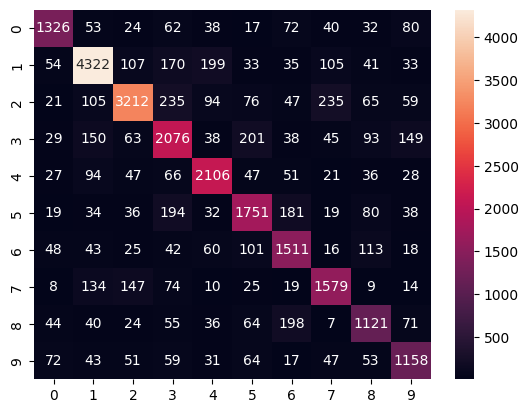

In [ ]:
conf_mtrx_df = pd.DataFrame(confusion_matrix)
sn.heatmap(conf_mtrx_df, annot=True, fmt="d");

## Exercise 3: nearest neighbor search

Rewrite the `forward` method of the classifier class to return the feature vector produced by the network right before the classification scores.

> **Note:** you don't have to retrain the model again!

Then, show the three nearest neighbors in the training set for element with index 0 in the test set.

In [ ]:
class SimpleClassifierBNv2(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #
        self.first = get_linear_bn_relu(input_dim, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.hidden_layers = nn.ModuleList([
            get_linear_bn_relu(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        ])
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #

    def forward(self, x):
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #
        x = self.first(x)
        for layer in self.hidden_layers:
            x = layer(x)

        return x
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #

In [ ]:
state_dict = torch.load("best_model.pth")

new_model = SimpleClassifierBNv2(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=3
)
new_model.load_state_dict(state_dict)
new_model.to(device)
new_model.eval();

In [ ]:
def get_feat_vecs(model, dl):
    feat_vecs = []
    labels = []
    # ==================================================================== #
    #                         YOUR CODE STARTS HERE                        #
    # ==================================================================== #
    with torch.no_grad():
      for data in dl:
          imgs, lbls = data
          imgs = imgs.to(device)
          lbls = lbls.to(device)

          vecs = model(imgs)

          feat_vecs.append(vecs)
          labels.append(lbls)

    feat_vecs = torch.cat(feat_vecs, dim=0)
    labels = torch.cat(labels, dim=0)
    # ==================================================================== #
    #                         YOUR CODE ENDS HERE                          #
    # ==================================================================== #

    return feat_vecs, labels

train_dl = DataLoader(
    train_subdset,
    batch_size=batch_size,
    shuffle=False  # no shuffle here
)
feat_vecs_train, labels_train = get_feat_vecs(new_model, train_dl)
feat_vecs_test, labels_test = get_feat_vecs(new_model, test_dl)

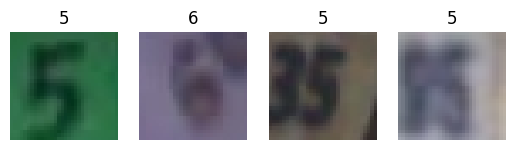

In [ ]:
test_idx = 0

# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
feat_vecs_train = F.normalize(feat_vecs_train, dim=1)
feat_vecs_test = F.normalize(feat_vecs_test, dim=1)
feat_vec_test = feat_vecs_test[test_idx].unsqueeze(0)

dist = torch.linalg.norm(feat_vecs_train - feat_vec_test, dim=1)
knn = dist.topk(3, largest=False)

_, ax = plt.subplots(1, 4)
for i in range(4):
    if i == 0:
        img, label = test_dset[test_idx]
    else:
        img, label = train_subdset[knn.indices[i - 1]]
    ax[i].imshow(img.reshape(3, 32, 32).permute(1, 2, 0))
    ax[i].set_title(label)
    ax[i].axis("off")
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #